In [323]:
import glob
import pandas as pd
import os
import csv
import matplotlib.pyplot as plt
from scipy.stats import norm, kstest, shapiro, ranksums
import numpy as np
from itertools import combinations

# Gets Data

In [363]:
#store all data, from all configs, in a dict with key config and value dataframe converted to dict format
all_configs_data = {}

#stores name of config to keep track of order and 
#id_configurations = []

for subdir, dirs, files in os.walk('Runs'):
    
    run = 0
    
    #messyCodeStillWorks; don't call it messy work, call it smart solution
    try:
        config = str(subdir).split('/')[1]
        #id_configurations.append(config)
    except: continue

    data = pd.DataFrame()
    
    for file in glob.glob(subdir + '/run_*.csv'):
        run +=1
        with open(file, 'r', newline='') as file:
            df = pd.read_csv(file, names = ['Generation','Fitness','Representation'])
            #MAX
            df = pd.DataFrame(df.groupby('Generation')['Fitness'].agg('max'))
            #MIN
            #df = pd.DataFrame(df.groupby('Generation')['Fitness'].agg('min'))
            data['Run_{}'.format(run)] = df['Fitness']
    
    #appends dataframe of current configuration in dict type, in list all_configs_data
    #all_configs_data.append(data.to_dict())
    all_configs_data[config] = data.to_dict()    
    


# Plotting Data + Statistics (Against Iterations)

In [325]:
def plot_n_stat_iter(*kwargs):
    
    #iteratable list of all arguments passed to function
    arguments = locals()
    
    df_plot = pd.DataFrame()
    dic_success = {}
    
    for config in arguments['kwargs']:
        
        #retrieve and convert wanted configs to pd.df format
        df = pd.DataFrame(all_configs_data[config])

        #creates ABF for data of current config
        df_plot['ABF_{}'.format(config)] = df.mean(axis=1) #or median
        df_plot['SD_{}'.format(config)] = df.std(axis=1)
        
        
        ##SUCCESS RATE!
        ##Creates dic of successes for each given configuration
        count_successes = 0
        #check sucesses
        for run in df.columns:
            
            success =  243 in df[run].unique()
            
            if success:
                count_successes += 1
                
        dic_success[config] = count_successes/100
    
    print('SUCCESSES:')
    print(dic_success)
    print('\n')
    
    #Testing for normality
    for column in range(0, len(df_plot.columns), 2):

        #histogram to visualize distribution of data
        #plt.hist(df_plot.iloc[:,column])
        #plt.show()
        
        #fits normal distribution to the data
        #loc, scale = norm.fit(df_plot.iloc[:,column])
        #n = norm(loc=loc, scale=scale)
        
        #Kolmogorov-Smirnov test
        #print(kstest(df_plot.iloc[:,column], n.cdf)) #sample size too small for this test
        
        
        stat, p = shapiro(df_plot.iloc[:,column]) #shapiro-wilk test (better than Kolmogorov-Smirnov test for small sample sizes)
        print('Shapiro-wilk test {}: statistics={}, p={}'.format(df_plot.columns[column], stat, p))
        
        if p < 0.05:
            print('Data does not follow Normal distribution.\n')
            
        else:
            print('Crap. - but dont think will happen.\n')
    
    
    #performs wilcoxon rank-sum btw all possible configurations
    #we're assuming none of the data will ever assume a Normal Distribution,
    #but this should be check manually according to previous print
    perform_wilcoxon(*kwargs)
    
        
    #lineplot of all configurations considered
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams.update({'font.size': 20})
    
    plt.figure(figsize = (10,7))
    
    legend_handles = []
    colors = ['darkgray', 'dodgerblue', 'forestgreen', 'darkorange', 'khaki', 'violet',]
    i = 0 #keep track color
    
    for column in range(0, len(df_plot.columns), 2):
        
        #plots line
        plt.plot(df_plot.index, df_plot.iloc[:,column],color=colors[i], linewidth = 4)
        
        #plots +- std
        plt.fill_between(df_plot.index, df_plot.iloc[:,column]-df_plot.iloc[:,column+1],
                         df_plot.iloc[:,column]+df_plot.iloc[:,column+1], alpha=0.15, edgecolor='white', facecolor=colors[i])
        
        
###     COMMENT THIS LINE IF FITNESS FUNC NOT MAXIMIZATION!
        plt.hlines(243, 0, len(df_plot), linestyles='dotted')
        
        #appends legend name
        legend_handles.append(str(df_plot.columns[column]) + ' \u00B1 std')
        
        i+=1
    
    plt.legend(legend_handles, bbox_to_anchor=(1.05, 1.4), frameon=False)
    
    plt.xlim([0,len(df_plot)])
    plt.ylim(210,246)
    #plt.ylim(0,100)
    
    plt.xlabel('Generation')
    plt.ylabel('ABF')
    
    plt.savefig('crossover.png', dpi=300, bbox_inches="tight")
    
    plt.show()
    
    return None

# Call Configurations to Benchmark here

SUCCESSES:
{'No_elitism': 0.01, 'elitism': 0.01}


Shapiro-wilk test ABF_No_elitism: statistics=0.6579434871673584, p=6.261502682449946e-14
Data does not follow Normal distribution.

Shapiro-wilk test ABF_elitism: statistics=0.6802141070365906, p=1.9101894003191455e-13
Data does not follow Normal distribution.

wilcoxon rank-sum test No_elitism and elitism: p=0.9930364627409765


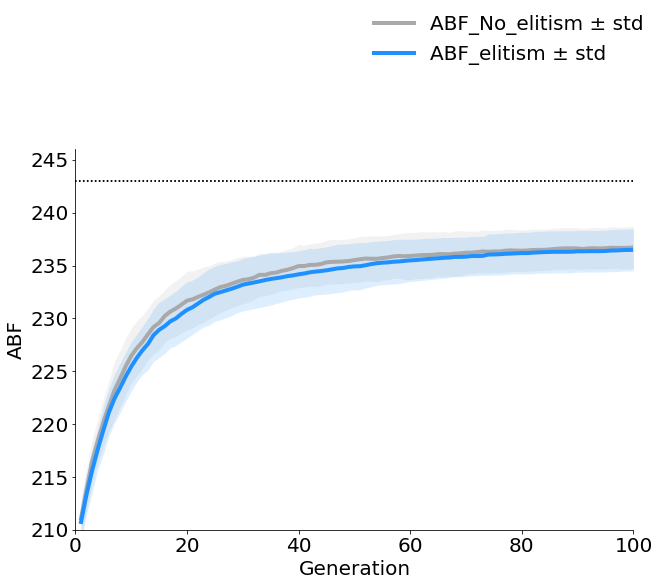

In [341]:
plot_n_stat_iter('No_elitism', 'elitism')


# Plotting Data + Statistics (Against Computational Effort)

In [327]:
def plot_n_stat_effort(*kwargs):
    
    #iteratable list of all arguments passed to function
    arguments = locals()
    
    df_plot = pd.DataFrame()
    dic_success = {}
    
    
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams.update({'font.size': 20})
    
    plt.figure(figsize = (10,7))
    
    legend_handles = []
    colors = ['dodgerblue', 'darkgray', 'forestgreen', 'darkorange', 'violet', 'darkcyan']
    
    i = 0 #keep track color
    
    for config in arguments['kwargs']:
        
        print(config)
        pop = int(input('write pop size for this config: '))
        
        #retrieve and convert wanted configs to pd.df format
        df = pd.DataFrame(all_configs_data[config])

        #creates ABF for data of current config
        df_plot['ABF'] = df.mean(axis=1) #or median
        df_plot['SD'] = df.std(axis=1)
        
        #creates x data
        df_plot['evaluations'] = pd.DataFrame([a*pop for a in range(0, len(df)+1)])
        
        #plots line
        plt.plot(df_plot.evaluations, df_plot.ABF,color=colors[i])
        
        #plots +- std
        plt.fill_between(df_plot.evaluations, df_plot.ABF-df_plot.SD,
                         df_plot.ABF+df_plot.SD, alpha=0.2, edgecolor='white', facecolor=colors[i])
        
        #appends legend name
        legend_handles.append(str(config) + ' \u00B1 std')
    
        ##SUCCESS RATE!
        ##Creates dic of successes for each given configuration
        count_successes = 0
        #check sucesses
        for run in df.columns:
            
            success =  243 in df[run].unique()
            
            if success:
                count_successes += 1
                
        dic_success[config] = count_successes/100
    
        i+=1
        
        #stats performed iqf so it doesn't mess up here
    #performs wilcoxon rank-sum btw all possible configurations
    #we're assuming none of the data will ever assume a Normal Distribution,
    #but this should be check manually according to previous print
    perform_wilcoxon(*kwargs)
        
### COMMENT THIS LINE IF FITNESS FUNC NOT MAXIMIZATION!
    plt.hlines(243, 0, 100000, linestyles='dotted')
    
    plt.legend(legend_handles, bbox_to_anchor=(1.05, 1.3), frameon=False)
        
    print('SUCCESSES:')
    print(dic_success)
    print('\n')
    
    
    plt.xlim([100,80000])
    plt.ylim(210,245)
    #plt.ylim(0,100)
    
    plt.xlabel('# Fitness Evaluation')
    plt.ylabel('ABF')
    
    plt.savefig('populations.png', dpi=300, bbox_inches="tight")
    
    plt.show()
        
        

pop100_gen800
write pop size for this config: 100
pop1000_gen80
write pop size for this config: 1000
pop2000gen40
write pop size for this config: 2000
wilcoxon rank-sum test pop100_gen800 and pop1000_gen80: p=1.308011260429183e-07
wilcoxon rank-sum test pop100_gen800 and pop2000gen40: p=2.6990571107696387e-07
wilcoxon rank-sum test pop1000_gen80 and pop2000gen40: p=0.9581041121246177
SUCCESSES:
{'pop100_gen800': 0.07, 'pop1000_gen80': 0.08, 'pop2000gen40': 0.13}




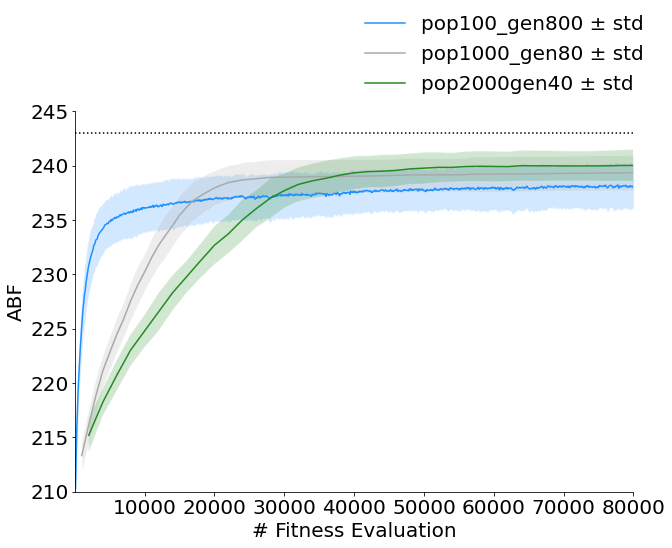

In [364]:
#plot_n_stat_effort('selection_tournament')
plot_n_stat_effort('pop100_gen800', 'pop1000_gen80', 'pop2000gen40')




In [359]:
def perform_wilcoxon(*kwargs):
    
    #iteratable list of all arguments passed to function
    arguments = locals()
    
    df_stats = pd.DataFrame()
    
    for config in arguments['kwargs']:
        
        #retrieve and convert wanted configs to pd.df format
        df = pd.DataFrame(all_configs_data[config]).iloc[-1::].transpose()

        #ads column to new df ready for stats
        df_stats[str(config)] = df[df.columns[-1]]
    
    #performs combinations on all possible configurations
    comb = combinations([i for i in range(len(df_stats.columns))], 2)
    
    for configuration_set in list(comb):
        #performs wilcoxon rank-sum test between all possible combinations of configurations and prints p-value
        stat, p = ranksums(df_stats.iloc[:,configuration_set[0]].to_list(), df_stats.iloc[:,configuration_set[1]].to_list())
        print('wilcoxon rank-sum test {} and {}: p={}'.format(
            df_stats.columns[configuration_set[0]],df_stats.columns[configuration_set[1]], p))
        
    return None

# Time 4 Fitness Analysis

In [255]:
#loads data
file = open(os.path.join('crosssover_cycle.csv'))
df_time = pd.read_csv(file, names = ['Running_Time_Cycle'])
df_time = df_time.iloc[1:,:] #corrects
file = open(os.path.join('crosssover_pmx.csv'))
df_time['Running_Time_PMX'] = pd.read_csv(file)
#file = open(os.path.join('running_times_factorial.csv'))
#df_time['Running_Time_Factorial'] = pd.read_csv(file)
#file = open(os.path.join('running_times_max.csv'))
#df_time['Running_Time_Cardinality'] = pd.read_csv(file)


In [262]:
df_time = df_time.iloc[:500,:]

In [335]:
#stats
#performs combinations on all possible configurations
comb = combinations([i for i in range(len(df_time.columns))], 2)

for configuration_set in list(comb):
        #performs wilcoxon rank-sum test between all possible combinations of configurations and prints p-value
        stat, p = ranksums(df_time.iloc[:,configuration_set[0]].to_list(), df_time.iloc[:,configuration_set[1]].to_list())
        print('wilcoxon rank-sum test {} and {}: p={}'.format(
            df_time.columns[configuration_set[0]],df_time.columns[configuration_set[1]], stat, p))
        

wilcoxon rank-sum test Running_Time_Cycle and Running_Time_PMX: p=-26.428205207344643


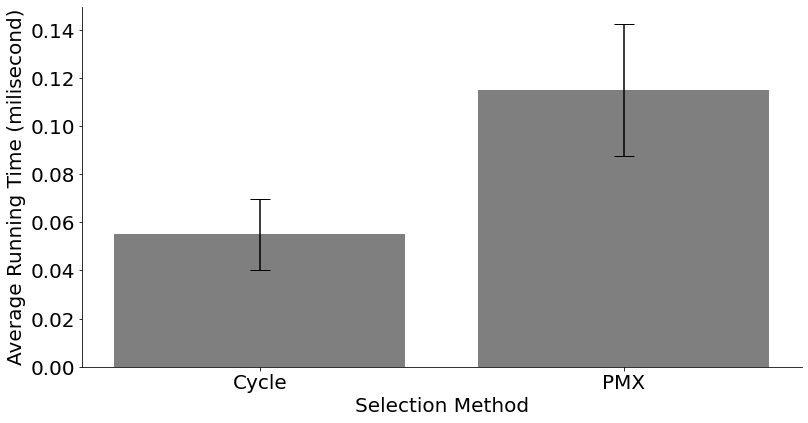

In [265]:
#plot
plt.rcParams.update({'font.size': 20})
fig = plt.figure(figsize = (10,5))
ax = fig.add_axes([0,0,1,1]) ###
config = ['Cycle', 'PMX']
times_mean = [df_time.iloc[:,0].mean(axis=0)*1000,df_time.iloc[:,1].mean(axis=0)*1000] #,df_time.iloc[:,2].mean(axis=0)*1000,df_time.iloc[:,3].mean(axis=0)*1000]
times_std = [df_time.iloc[:,0].std(axis=0)*1000,df_time.iloc[:,1].std(axis=0)*1000]#,df_time.iloc[:,2].std(axis=0)*1000,df_time.iloc[:,3].std(axis=0)*1000]
ax.bar(config,times_mean,color = 'black', yerr = times_std, align='center',alpha=0.5,ecolor='black',capsize=10)
plt.xlabel('Selection Method')
plt.ylabel('Average Running Time (milisecond)')
plt.savefig('running_times_tournament_rank.png', dpi=300, bbox_inches="tight")
plt.show()
